In [1]:
import sys
sys.path.append('../web/')

In [13]:
from itertools import cycle
from random import choice

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from scikits.audiolab import aiffread
from librosa import frames_to_time
from librosa.onset import onset_detect, onset_strength
from librosa.feature import melspectrogram
from IPython.display import Audio

import utils

### Load the audio file
The first step is to load the audio file. I snipped a bunch of samples from an episode of Dr. Katz, Professional Therapist [S3E5, Koppleman and Katz](https://www.youtube.com/watch?v=YUVqMFVeQVg). Here's Dr. Katz saying *"She was my partner in life."*

In [3]:
vox_48k, sr_48k, _ = aiffread('../audio/k08.aif')
t_48k = np.arange(vox_48k.size, dtype=float)/sr_48k
Audio(data=vox_48k, rate=sr_48k)

### Preprocessing
You can read more about these steps in the `pitch_track.ipynb` notebook

In [4]:
downsample = 4
vox_12k = vox_48k[::downsample]
sr_12k = sr_48k/downsample
t_12k = t_48k/4.

nfft = 1024
frame_size = nfft
hop_length = 256

vox_windowed = utils.frame_and_window_sound(vox_12k, hop_length=hop_length)
t_frames = frames_to_time(np.arange(vox_windowed.shape[1]), sr=sr_12k, hop_length=hop_length) + (frame_size/2.)/sr_12k

vox_fft = np.fft.rfft(vox_windowed, n=nfft, axis=0)
autocorr, periodicity, is_voiced = utils.calc_vocal_periodicity(vox_fft, voiced_thresh=1.5)
is_voiced_sum = is_voiced.sum()

vox_spectrogram = np.abs(vox_fft)

### Rhythm
The rhythm of speech is extracted by taking onset times from the audio waveform. These are computed by the `librosa` functions `onset_strength`, which computes a *spectral flux*, or how much the spectrogram changes from one frame to the next.

In [6]:
is_speech = np.convolve(is_voiced, np.ones(10.)/10., 'same')>0
t_spec = t_frames[is_speech]
mel_spectrogram_speech = melspectrogram(S=np.abs(vox_fft[5:213,is_speech])**2)

onset_env = onset_strength(S=mel_spectrogram_speech)
onset_frames = onset_detect(onset_envelope=onset_env, pre_max=3, post_max=4)

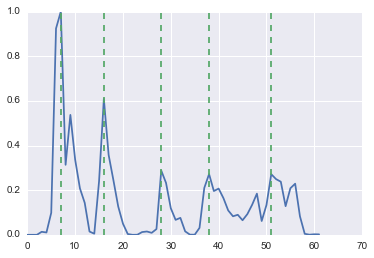

In [8]:
color_cycle = cycle(sns.color_palette())
color = next(color_cycle)
plt.plot(onset_env, color=color);
color = next(color_cycle)
for i in onset_frames:
    plt.axvline(i, color=color, ls='--');

The onsets provide the timing of rhythmic events in the speech, but we need to quantize these as part of the "musification."

In [40]:
onset_times = t_spec[onset_frames]
onset_samples = (onset_times*sr_12k).astype(int)
subdiv = (15./120.) # 16th note period @ 120 bpm

onset_times_quant = utils.quantize_onset_times(onset_times, subdiv)
print 'Quantized onset times:', onset_times_quant, 'seconds'

Quantized onset times: [0.0, 0.25, 0.5, 0.75, 1.0] seconds


Now we have quantized onset times, but need to get the sounds that will be triggered at those times. Around each of the onsets (unquantized), we take a tiny chunk of the audio waveform and perform granular synthesis over these chunks. The length of those is randomly chosen from to provide some variety of timbres in the final sound. Here are the relevant granular synthesis parameters:
 - grain duration is either 0.01 or 0.02 seconds
 - grain density is 100
 - deviation of grain onset is 10%
 - envelope attack and release are both 3 ms

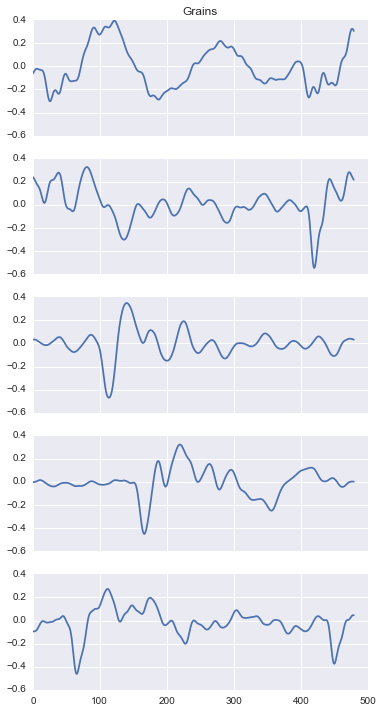

In [45]:
vox_samp = []
dur = choice([0.01, 0.01, 0.01, 0.02])
dev = 0.1
if dur==0.01:
    ampl = 0.7
elif dur==0.02:
    ampl = 0.55
vox_samp_pos = [0 + int((dur*dev)*sr_48k)]
vox_samp_length = int(dur*sr_48k)

fig, axs = plt.subplots(len(onset_times), figsize=(6, 12), sharex=True, sharey=True)
for i, onset in enumerate(onset_times):
    onset_ix_start = int(onset*sr_48k)
    onset_ix_stop = onset_ix_start+vox_samp_length
    vox_samp_ = vox_48k[onset_ix_start:onset_ix_stop]
    if vox_samp_.size<vox_samp_length:
        vox_samp_ = np.r_[vox_samp_, vox_samp_[:(vox_samp_length-vox_samp_.size)]]
    vox_samp.append(vox_samp_)
    vox_samp_pos.append(vox_samp_pos[-1]+vox_samp_.size)
    axs[i].plot(vox_samp_)
vox_samp_pos.pop()
vox_samp = np.asarray(vox_samp).flatten()
axs[0].set_title('Grains');

Now we pass those quantized onset times and grains into the `Rhythm` object, and it instantiates a custom `PyoObject` that we can play in our piece.